In [1]:
# Install PGBM. 
%pip install pgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
#%% Load packages
import torch
from pgbm import PGBM
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

Using C:\Users\ospra\AppData\Local\torch_extensions\torch_extensions\Cache\py38_cu113 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file C:\Users\ospra\AppData\Local\torch_extensions\torch_extensions\Cache\py38_cu113\split_decision\build.ninja...
Building extension module split_decision...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module split_decision...


In [3]:
#%% Objective for pgbm
def mseloss_objective(yhat, y, levels=None):
    gradient = (yhat - y)
    hessian = torch.ones_like(yhat)

    return gradient, hessian

def rmseloss_metric(yhat, y, levels=None):
    loss = (yhat - y).pow(2).mean().sqrt()

    return loss

In [4]:
#%% Load data
X, y = fetch_california_housing(return_X_y=True)
params = {'device':'cpu'}

In [5]:
#%% Train pgbm
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
train_data = (X_train, y_train)
test_data = (X_test, y_test)
# Train on set 
model = PGBM()  
model.train(train_data, objective=mseloss_objective, metric=rmseloss_metric, params=params)
#% Point and probabilistic predictions. By default, 100 probabilistic estimates are created
yhat_point = model.predict(test_data[0])
yhat_dist = model.predict_dist(test_data[0])
# Scoring
rmse = model.metric(yhat_point, test_data[1])
crps = model.crps_ensemble(yhat_dist, test_data[1]).mean()    
# Print final scores
print(f'RMSE PGBM: {rmse:.2f}')
print(f'CRPS PGBM: {crps:.2f}')

Estimator 0/100, Train metric: 1.0840
Estimator 1/100, Train metric: 1.0206
Estimator 2/100, Train metric: 0.9661
Estimator 3/100, Train metric: 0.9172
Estimator 4/100, Train metric: 0.8725
Estimator 5/100, Train metric: 0.8346
Estimator 6/100, Train metric: 0.8007
Estimator 7/100, Train metric: 0.7719
Estimator 8/100, Train metric: 0.7458
Estimator 9/100, Train metric: 0.7231
Estimator 10/100, Train metric: 0.7035
Estimator 11/100, Train metric: 0.6852
Estimator 12/100, Train metric: 0.6696
Estimator 13/100, Train metric: 0.6561
Estimator 14/100, Train metric: 0.6426
Estimator 15/100, Train metric: 0.6310
Estimator 16/100, Train metric: 0.6220
Estimator 17/100, Train metric: 0.6132
Estimator 18/100, Train metric: 0.6046
Estimator 19/100, Train metric: 0.5943
Estimator 20/100, Train metric: 0.5858
Estimator 21/100, Train metric: 0.5777
Estimator 22/100, Train metric: 0.5684
Estimator 23/100, Train metric: 0.5598
Estimator 24/100, Train metric: 0.5549
Estimator 25/100, Train metric: 0.5

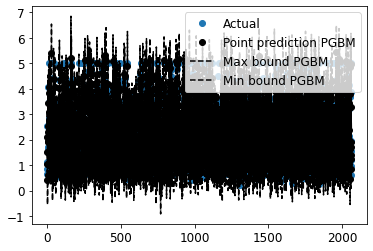

In [6]:
#%% Plot all samples
plt.rcParams.update({'font.size': 12})
plt.plot(y_test, 'o', label='Actual')
plt.plot(yhat_point.cpu(), 'ko', label='Point prediction PGBM')
plt.plot(yhat_dist.cpu().max(dim=0).values, 'k--', label='Max bound PGBM')
plt.plot(yhat_dist.cpu().min(dim=0).values, 'k--', label='Min bound PGBM')
plt.legend()